<a href="https://colab.research.google.com/github/askhatsametov/MNISTclassification/blob/main/alexnetMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from  torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.optim.lr_scheduler import StepLR
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import lr_scheduler
from tempfile import TemporaryDirectory
import os
import time

from torch.utils.data import random_split
%matplotlib inline

In [ ]:
batch_size=128
val_size = 10000

torch.manual_seed(1)

dataset = MNIST(root='data/', download=True, transform=ToTensor())

train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 189612259.23it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 41202616.95it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39236428.71it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22049223.11it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
train_mean = 0.
train_std = 0.
for images, _ in train_loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)

    train_mean += images.mean(2).sum(0)
    train_std += images.std(2).sum(0)

train_mean /= len(train_loader.dataset)
train_std /= len(train_loader.dataset)

print('Mean: ', train_mean)
print('Std: ', train_std)

Mean:  tensor([0.1307])
Std:  tensor([0.3016])


In [ ]:
dataset = MNIST(root='data/', download=True, transform=transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.Grayscale(3),
                        #transforms.RandomRotation((-7.0,7.0),fill=(1,)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1308,), (0.3016,))
                    ]))
test_dataset = MNIST(root='data/', train=False,transform=transforms.Compose([
                        transforms.Resize(256),
                        transforms.CenterCrop(224),
                        transforms.Grayscale(3),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1308,), (0.3016,))
                    ]))

In [ ]:
torch.manual_seed(1)
# split to training and validation
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size=128

train_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
#val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
img, label = next(iter(train_loader))
img.shape

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 3, 28, 28])

torch.Size([1, 28, 28])
min value tensor(-0.4337)
max value tensor(2.8820)
Mean tensor(0.0170)
Std deviation tensor(1.0404)


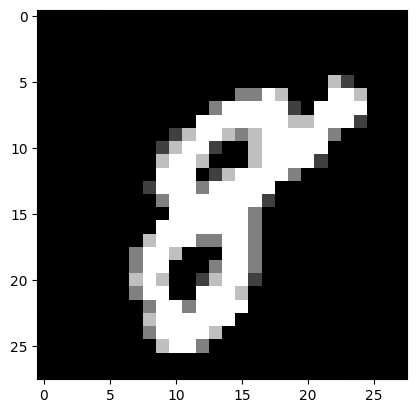

In [ ]:
imgs, lbls = next(iter(train_loader))

print(imgs[7].data.shape)
print("min value", imgs.data.min())
print("max value",imgs.data.max())
print("Mean",imgs.data.mean())
print("Std deviation",imgs.data.std())
plt.imshow(imgs[0].data.reshape((28,28)), cmap="gray")

In [ ]:
def show_batch(dl, invert=False):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break

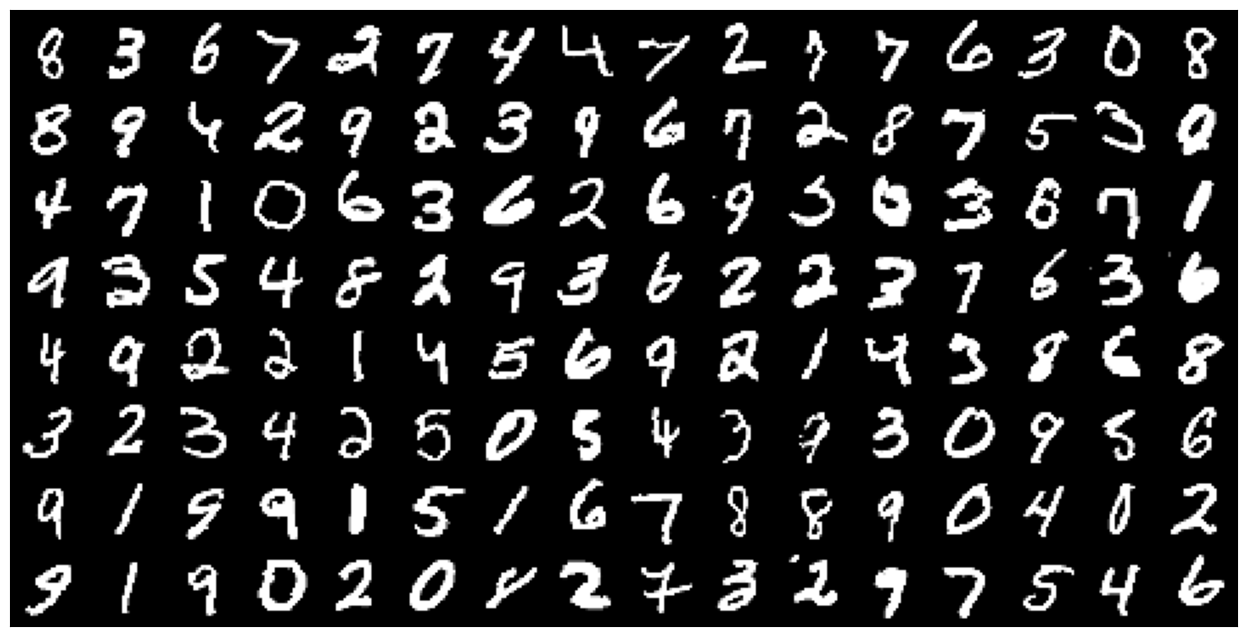

In [ ]:
show_batch(train_loader)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
alex_net = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
alex_net

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 300MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
for param in alex_net.parameters():
    param.requires_grad = False

num_classes = 10
alex_net.classifier = nn.Linear(alex_net.classifier[1].in_features, num_classes)

#alex_net.classifier[4] = nn.Linear(4096, 1024)
#alex_net.classifier[6] = nn.Linear(1024, 10)
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=10, bias=True)
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
alex_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex_net.parameters(), lr=0.001, momentum=0.9)

accs = []

for epoch in range(10):
    print(epoch)
    alex_net.train()
    running_loss = 0.
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(inputs.shape)
        optimizer.zero_grad()
        output = alex_net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print test metrics
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Test Loss: {avg_loss}, Test Accuracy: {avg_accuracy}%")
    accs.append(avg_accuracy)
print("done")

0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1, Test Loss: 0.032723538424652907, Test Accuracy: 99.13%
1
Epoch 2, Test Loss: 0.029282565229633916, Test Accuracy: 99.22%
2
Epoch 3, Test Loss: 0.02662909422705232, Test Accuracy: 99.315%
3
Epoch 4, Test Loss: 0.024521286172399133, Test Accuracy: 99.385%
4
Epoch 5, Test Loss: 0.022670056588495018, Test Accuracy: 99.425%
5
Epoch 6, Test Loss: 0.021078863513292564, Test Accuracy: 99.48833333333333%
6


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e68b695a3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e68b695a3b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch 7, Test Loss: 0.01993631504611102, Test Accuracy: 99.50666666666666%
7
Epoch 8, Test Loss: 0.018866293674914728, Test Accuracy: 99.53833333333333%
8
Epoch 9, Test Loss: 0.017837155199270132, Test Accuracy: 99.59%
9
Epoch 10, Test Loss: 0.016888111680825508, Test Accuracy: 99.62%
done


In [ ]:
alex_net.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alex_net(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = running_test_loss / len(test_loader)
avg_test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.0261, Test Accuracy: 99.15%


In [ ]:
for param in alex_net.parameters():
    param.requires_grad = True

alex_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex_net.parameters(), lr=0.0001, momentum=0.9)

#alex_net.classifier[4] = nn.Linear(4096, 1024)
#alex_net.classifier[6] = nn.Linear(1024, 10)
alex_net

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=10, bias=True)
)

In [ ]:
accs = []

for epoch in range(10):
    print(epoch)
    alex_net.train()
    running_loss = 0.
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        #print(inputs.shape)
        optimizer.zero_grad()
        output = alex_net(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()


        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print test metrics
    avg_loss = running_loss / len(train_loader)
    avg_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Test Loss: {avg_loss}, Test Accuracy: {avg_accuracy}%")
    accs.append(avg_accuracy)
print("done")

0


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1, Test Loss: 0.013767619927558723, Test Accuracy: 99.65333333333334%
1
Epoch 2, Test Loss: 0.01240027649675621, Test Accuracy: 99.665%
2
Epoch 3, Test Loss: 0.011515528669763011, Test Accuracy: 99.68%
3
Epoch 4, Test Loss: 0.010919545834232717, Test Accuracy: 99.68833333333333%
4
Epoch 5, Test Loss: 0.010406834125863329, Test Accuracy: 99.72166666666666%
5
Epoch 6, Test Loss: 0.010019348988808177, Test Accuracy: 99.72666666666667%
6
Epoch 7, Test Loss: 0.009583515872340352, Test Accuracy: 99.74333333333334%
7
Epoch 8, Test Loss: 0.009175184977003563, Test Accuracy: 99.76333333333334%
8
Epoch 9, Test Loss: 0.00882600314029282, Test Accuracy: 99.77833333333334%
9
Epoch 10, Test Loss: 0.008509748070480933, Test Accuracy: 99.78%
done


In [ ]:
alex_net.eval()

running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = alex_net(images)
        loss = criterion(outputs, labels)

        # Collect test statistics
        running_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = running_test_loss / len(test_loader)
avg_test_accuracy = 100 * correct_test / total_test
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.2f}%")


Test Loss: 0.0226, Test Accuracy: 99.22%
